<a href="https://colab.research.google.com/github/vitorbdiniz/python-applied-to-finance/blob/main/Portolios'%20Beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução

Dando sequência ao estudo de Python, iniciaremos agora uma abordagem mais aplicada a finanças. Já temos alguns textos introduzindo a linguagem na categoria [Quant & Investimentos](https://tc.com.br/tc-school/quant-investimentos/), então, se você ainda não entende como funciona um script básico, dá uma olhada lá antes de seguir a leitura.

Hoje iremos discutir o cálculo do beta de um portfólio, o coeficiente angular do modelo do CAPM de Sharpe (1977), discutindo por Filipe Duarte em [Python: Modelo de Precificação de Ativos (CAPM)
](https://tc.com.br/tc-school/quant-investimentos/python-capm/), sem a necessidade de realizar a regressão. Para isso, este artigo está divido em 2 partes:
- Portfólio com retornos conhecidos
- Portfólio sem retornos conhecidos

#Cálculo do Beta

Antes de iniciarmos o código, precisamos entender que o beta é calculado da seguinte forma:

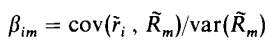

Imagem retirada da referência [1].

Em que, 
- β é o beta do portfólio i em relação ao índice de mercado m; 
- COV(r,R) é a covariância entre os retornos do portfólio (r) e do mercado (R);
- VAR (R) é a variância dos retornos do mercado.

#Importando Bibliotecas e Buscando Dados

Tendo isso em mente, vamos precisar importar: 

- a biblioteca `pandas` para manipular DataFrames;
- a biblioteca `pandas-datareader` para acessar a API gratuita de cotações do Yahoo;
- o módulo `random` da biblioteca `numpy` para gerar retornos;
- a função `cov` da biblioteca `numpy` para calcular a covariância;
- a função `variance` da biblioteca `statistics` para calcular a variância.

In [ ]:
import pandas as pd
import pandas_datareader as web
from numpy import cov, random
from statistics import variance

Buscaremos, primeiramente, as cotações de fechamento para cada mês dos últimos 60 do Ibovespa (o considerando como representação do mercado) através da interface para a API do Yahoo: 

In [ ]:
ibov = web.get_data_yahoo("^BVSP", start="2016-03-24", end="2021-02-24").resample("M").pad()[["Close"]]
ibov.tail(5)

,Close
Date,
2020-10-31,93952.00000
2020-11-30,108888.00000
2020-12-31,119306.00000
2021-01-31,116007.00000
2021-02-28,115667.78125


Entretanto, o que nos interessa são os retornos mensais. Para isso, definiremos uma função que realiza tal cálculo:

In [ ]:
def retornos(precos):
  resultado = [0]
  for i in range(1, len(precos)):
    resultado.append(precos[i]/precos[i-1] -1)
  return resultado


Para quem deseja escrever um código mais eficiente, a função `retornos` pode ser escrita como uma função `lambda`, da seguinte forma:

In [ ]:
retornos = lambda precos : [0]+[ precos[i]/precos[i-1] -1 for i in range(1, len(precos)) ]

Com isso, podemos aplicar a função e encontrar nossos retornos

In [ ]:
ibov["retornos"] = retornos(ibov["Close"])
ibov.tail(5)

,Close,retornos
Date,,
2020-10-31,93952.00000,-0.006881
2020-11-30,108888.00000,0.158975
2020-12-31,119306.00000,0.095676
2021-01-31,116007.00000,-0.027652
2021-02-28,115667.78125,-0.002924


Agora podemos começar a pensar no nosso beta.

#Portólio com retornos conhecidos

Considere que sua carteira obteve os seguintes retornos mensais nos últimos 60 meses (5 anos):

In [ ]:
carteira = pd.DataFrame({"retornos":random.rand(60) * ibov["retornos"]})
carteira

,retornos
Date,
2016-03-31,0.000000
2016-04-30,0.000670
2016-05-31,-0.099181
2016-06-30,0.005090
2016-07-31,0.076222
2016-08-31,0.001461
2016-09-30,0.007037
2016-10-31,0.066695
2016-11-30,-0.021906


Com isso, podemos calcular o beta do nosso portfólio aplicando a fórmula de Sharpe descrita anteriormente

In [ ]:
beta_portfolio_com_retornos = cov(carteira["retornos"], ibov["retornos"])[0][1] / variance(ibov["retornos"])
print(f"O beta do portfólio é {beta_portfolio_com_retornos:.3f}")

O beta do portfólio é 0.617


De uma forma direta, conseguimos descobrir o beta do nosso portfólio.

#Portfólio sem retornos conhecidos

Contudo, a facilidade apresentada anteriormente se torna mais distante quando o investidor não sabe ao certo quais foram suas rentabilidades mensais dos últimos períodos.

Para tanto, calcularemos o beta do portfólio como a média ponderada dos betas dos ativos que o compõem.

Suponha, então, que seu portfólio é composto pelos seguintes ativos:

1. ITSA4 (12%)
2. B3SA3 (11%)
3. EGIE3 (11%)
4. KLBN11 (10%)
5. WEGE3 (9%)
6. MDIA3 (9%)
7. LREN3 (8%)
8. VVAR3 (8%)
9. AAPL34 (6%)
10. BERK34 (6%)

Além disso, você manteve 10% em caixa.


Em seguida, iremos calcular cada beta individualmente encapsulando a fórmula do beta em uma função (`beta`) e colocando-a dentro de um laço para calcular de todos os ativos.

In [ ]:
#Função do beta
beta = lambda carteira, ibov : cov(carteira, ibov)[0][1] / variance(ibov)

In [ ]:
ativos = {"ITSA4":0.12, "B3SA3":0.11, "EGIE3":0.11, "KLBN11":0.1, "WEGE3":0.09, "MDIA3":0.09, "LREN3":0.08, "VVAR3":0.08, "AAPL34":0.06, "BERK34":0.06}

In [ ]:
def calcula_betas(mercado, ativos):
  betas = dict()
  for ativo in ativos:
    r = web.get_data_yahoo(ativo+".SA", start="2016-03-24", end="2021-02-24").resample("M").pad()[["Close"]]
    returns = retornos(r["Close"])
    betas[ativo] = beta(returns, mercado)
  return betas

In [ ]:
betas = calcula_betas(ibov["retornos"], ativos.keys())

Agora já temos os betas de cada ativo, como podemos ver abaixo:

In [ ]:
for ativo in betas:
  print(f"O beta de {ativo} é {betas[ativo]:.2f}")

O beta de ITSA4 é 1.11
O beta de B3SA3 é 0.99
O beta de EGIE3 é 0.67
O beta de KLBN11 é 0.28
O beta de WEGE3 é 0.55
O beta de MDIA3 é 0.73
O beta de LREN3 é 0.97
O beta de VVAR3 é 1.84
O beta de AAPL34 é -0.25
O beta de BERK34 é -0.23


Vamos agora calcular a média ponderada dos betas.

In [ ]:
beta_portfolio_sem_retornos = 0
for ativo in ativos:
  beta_portfolio_sem_retornos += betas[ativo] * ativos[ativo]
print(f"O beta do portfólio é {beta_portfolio_sem_retornos:.3f}")

O beta do portfólio é 0.656


#Conclusão

Aprendemos, então, que para calcular o beta de um portfólio qualquer, basta aplicar o cálculo de forma direta utilizando os retornos do mercado e do portfólio. Todavia, caso o investidor não saiba quais são seus retornos, é possível calculá-lo através da média ponderada do beta de cada ativo que compõe a carteira.

#Bibliografia

[1] SHARPE, William F. The capital asset pricing model: a “multi-beta” interpretation. In: **Financial Dec Making Under Uncertainty**. Academic Press, 1977. p. 127-135.